In [3]:
import os
import librosa # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.preprocessing import LabelEncoder # type: ignore
from sklearn.metrics import accuracy_score, f1_score, classification_report , confusion_matrix, ConfusionMatrixDisplay # type: ignore
from sklearn.ensemble import GradientBoostingClassifier # type: ignore
from IPython.display import Audio # type: ignore
import seaborn as sns  # type: ignore
import pickle
from scipy.signal import butter, lfilter # type: ignore
import noisereduce as nr # type: ignore
from scipy.io import wavfile # type: ignore
import datetime

/Users/panya/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [5]:
######### Data Pre-Processing ###########
# Set the path to dataset folder
print("#: Set the path to dataset folder")
data_dir = "/Users/panya/Project-ALL/DroneClassification/AcousticDroneDetection/dataset/train"

#: Set the path to dataset folder


In [6]:
# Load and preprocess audio data using spectrograms
#labels = os.listdir(data_dir)  # Read label form folder name 

timeperiod = 2
labels = ['Drone','No_Drone']
audio_data = []
target_labels = []

# Sample rate and desired cutoff frequencies (in Hz).
order = 4
lowcut = 200.0
highcut = 1200.0

for label in labels:
    label_dir = os.path.join(data_dir, label)
    for audio_file in os.listdir(label_dir):
        audio_path = os.path.join(label_dir, audio_file)
        print(audio_path)
        
        # Import Audio File
        audio_original, sample_rate = librosa.load(audio_path, duration=timeperiod)  # Load audio and limit to 3 seconds

        # normalize audio  
        max_value = np.max(np.abs(audio_original))       # Determine the maximum values
        audio_normalize = audio_original/max_value        # Use max_value and normalize sound data to get values between -1 & +1

        # band pass filter 
        audio_BPF = butter_bandpass_filter(audio_normalize,lowcut,highcut,sample_rate,order=7)
        
        # Noise reduce
        Audio_Reduced_Noise = nr.reduce_noise(y=audio_BPF, sr=sample_rate,prop_decrease = 0.98)

        # convert to spectrogram 
        spectrogram = librosa.feature.melspectrogram(y=Audio_Reduced_Noise, sr=sample_rate)
        spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

        # Transpose the spectrogram to have the shape (timesteps, n_mels)
        spectrogram = spectrogram.T
        audio_data.append(spectrogram)
        target_labels.append(label)

/Users/panya/Project-ALL/DroneClassification/AcousticDroneDetection/dataset/train/Drone/Drone_796.wav
/Users/panya/Project-ALL/DroneClassification/AcousticDroneDetection/dataset/train/Drone/Drone_782.wav
/Users/panya/Project-ALL/DroneClassification/AcousticDroneDetection/dataset/train/Drone/Drone_972.wav
/Users/panya/Project-ALL/DroneClassification/AcousticDroneDetection/dataset/train/Drone/Drone_966.wav
/Users/panya/Project-ALL/DroneClassification/AcousticDroneDetection/dataset/train/Drone/Drone_1017.wav
/Users/panya/Project-ALL/DroneClassification/AcousticDroneDetection/dataset/train/Drone/Drone_755.wav
/Users/panya/Project-ALL/DroneClassification/AcousticDroneDetection/dataset/train/Drone/Drone_741.wav
/Users/panya/Project-ALL/DroneClassification/AcousticDroneDetection/dataset/train/Drone/Drone_999.wav
/Users/panya/Project-ALL/DroneClassification/AcousticDroneDetection/dataset/train/Drone/Drone_1003.wav
/Users/panya/Project-ALL/DroneClassification/AcousticDroneDetection/dataset/trai

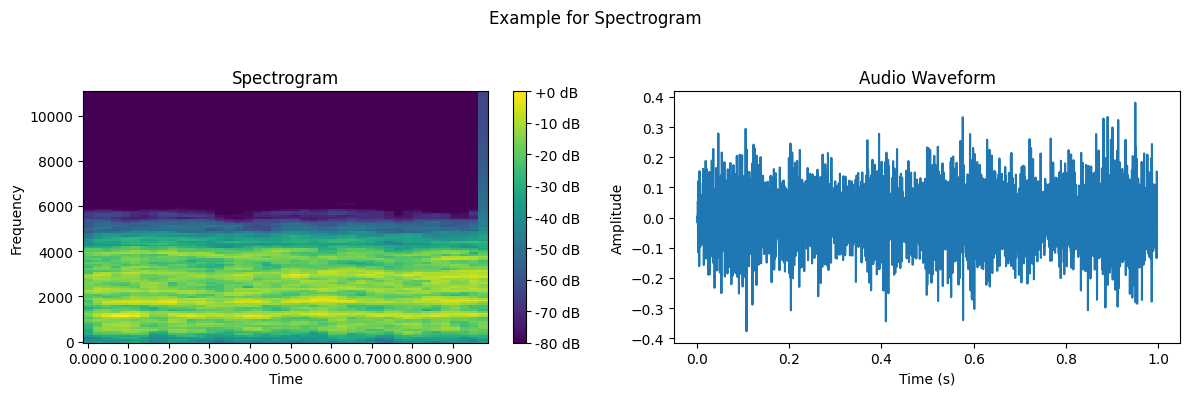

In [8]:
#Example to show spectrogram data 
audio_path = "./dataset/train/Drone/Drone_0.wav"
audio_original, sample_rate = librosa.load(audio_path, duration=3)  # Load audio and limit to 3 seconds

# normalize audio  
max_value = np.max(np.abs(audio_original))       # Determine the maximum values
audio_normalize = audio_original/max_value        # Use max_value and normalize sound data to get values between -1 & +1

# band pass filter 
audio_BPF = butter_bandpass_filter(audio_normalize,lowcut,highcut,sample_rate,order=7)

# Noise reduce
Audio_Reduced_Noise = nr.reduce_noise(y=audio_BPF, sr=sample_rate,prop_decrease = 1)

# convert to spectrogram 
spectrogram = librosa.feature.melspectrogram(y=Audio_Reduced_Noise, sr=sample_rate)
spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

plt.figure(figsize=(12, 4))
plt.suptitle(f'Example for Spectrogram')
plt.subplot(1, 2, 1)
plt.title(f'Spectrogram')
librosa.display.specshow(spectrogram, x_axis='time', y_axis='hz',cmap='viridis')  #cmap = 'viridis', 'plasma', 'inferno', 'magma', 'cividis'
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.title(f'Audio Waveform')
plt.plot(np.linspace(0, len(Audio_Reduced_Noise) / sample_rate, len(Audio_Reduced_Noise)), Audio_Reduced_Noise)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [9]:
######## Encoding targets and data-splitting #######
print("#: Encoding targets and data-splitting")
print("labels:")
print(labels)

# Encode target labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(target_labels)
#print("target_labels: ") 
#print(target_labels)
#print("label_encoder: ") 
#print(encoded_labels)

#: Encoding targets and data-splitting
labels:
['Drone', 'No_Drone']


In [10]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(audio_data, encoded_labels, test_size=0.2, random_state=42)

# Ensure all spectrograms have the same shape
max_length = max([spec.shape[0] for spec in audio_data])
X_train = [np.pad(spec, ((0, max_length - spec.shape[0]), (0, 0)), mode='constant') for spec in X_train]
X_test = [np.pad(spec, ((0, max_length - spec.shape[0]), (0, 0)), mode='constant') for spec in X_test]
 
# Convert to NumPy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)

In [11]:
print(y_train)

[0 0 1 ... 0 1 1]


In [12]:
######## Exploratory data analysis #######
# Count the number of samples in each class
print("#: Count the number of samples in each class")
class_counts = [len(os.listdir(os.path.join(data_dir, label))) for label in labels]

print("Total Data set: " + str(int(class_counts[0]) + int(class_counts[1])))
print(labels[0] + ": " + str(class_counts[0]))
print(labels[1] + ": " + str(class_counts[1]))
print()

print("Data set for train: " + str(X_train.shape[0]))
print("Data set for Test: " + str(X_test.shape[0]))

#: Count the number of samples in each class
Total Data set: 1735
Drone: 1018
No_Drone: 717

Data set for train: 1388
Data set for Test: 347


In [13]:
######## Model fitting and evaluation#######
# Convert the data to a flat 2D shape
print("#: Convert the data to a flat 2D shape")
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

#: Convert the data to a flat 2D shape


In [14]:
# Create Gradient Boosting classifier
print("Create Gradient Boosting classifier")
#model = GradientBoostingClassifier(random_state=42)
model = GradientBoostingClassifier(n_estimators=1000, learning_rate=1,max_depth=4, random_state=42)

Create Gradient Boosting classifier


In [ ]:
# Train the model
print("#: Train the model")
model.fit(X_train_flat, y_train)

In [16]:
y_train.shape

(1388,)

In [23]:
# save the iris classification model as a pickle file
model_pkl_file = "model/" + str(datetime.datetime.now()) + ".pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model, file)

In [24]:
# load AI model from pickle file
with open(model_pkl_file, 'rb') as file:  
    model = pickle.load(file)

In [ ]:
# Make predictions
print("#: Make predictions")
y_pred = model.predict(X_test_flat)

In [ ]:
# Calculate accuracy and F1 score
print("#: Calculate accuracy and F1 score")
accuracy = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred)
ConfusionMatrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
#print('Accuracy: {:.2f}'.format(accuracy))
print('F1 score: {:.2f}'.format(f1))

# Print classification report
print(classification_report(y_test, y_pred, target_names=labels))

In [ ]:
# Generate the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=ConfusionMatrix, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

#Customizations
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)

plt.show()